In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import imageio
from torch import nn
%matplotlib inline

## Problem definition
Suppose we have a time series P(t). P(t) is the solution of a differential equation $$ \frac{dP}{dt} = f(t,P(t))$$ We don't know the differential equation, nor the solution-time series P(t). We have some points (ti, pi) but not P(t). 

## time series - sine data


Let's suppose a simple example, P(t) = sint, which is solution of diff.eq P'(t) = cost. 
##### We pretend like we don't know P(t), just some points (ti,pi), specifically we have 100 points in (-10,10).

# First approach :
One first approach is to approximate P(t) with interpolation, for example a Neural Network. We can use also other models like splines. Neural Network is a continues function approximator with great results, for this reason is a good choice. 

### Model 1 
- a Neural Network with one hidden layer

In [3]:
#define model 1
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()                          #n_feature = 1 (the ti of each yi)
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer (n_hidden = neurons of hidden layer)
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer (n_output=1, the correspoding yi of ti)

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [4]:
net = Net(n_feature=1, n_hidden=200, n_output=1)   #200 hidden neurons

In [5]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()

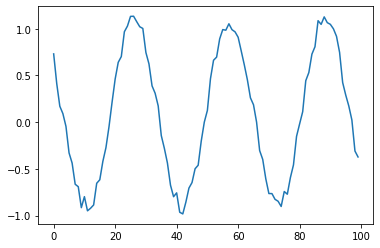

In [6]:
x = torch.unsqueeze(torch.linspace(-10, 10, 100), dim=1) 

y = torch.sin(x) + 0.2*torch.rand(x.size())  # noise
x, y = Variable(x), Variable(y)
plt.plot(y)

In [7]:
#we keep model 1 but with adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()

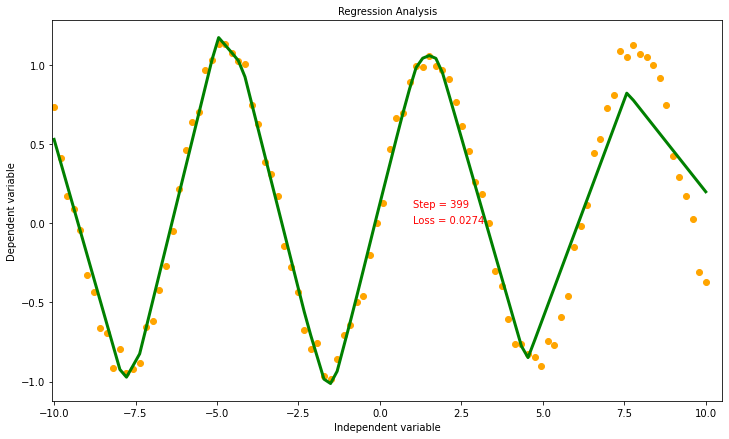

In [9]:
#training
epochs = 400

my_images = []
fig, ax = plt.subplots(figsize=(12,7))
losses=[]
for t in range(epochs):
  
    y_pred = net(x)     # input x and predict based on x

    loss = loss_func(y_pred, y)     

    optimizer.zero_grad()   # clear gradients for next epoch
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    losses.append(loss)
    # plot and show learning process
    plt.cla()
    ax.set_title('Regression Analysis', fontsize=10)
    ax.set_xlabel('Independent variable', fontsize=10)
    ax.set_ylabel('Dependent variable', fontsize=10)
    ax.set_xlim(-10.05, 10.5)
    #ax.set_ylim(-0.25, 1.25)
    ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
    ax.plot(x.data.numpy(), y_pred.data.numpy(), 'g-', lw=3)
    ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 10, 'color':  'red'})
    ax.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),
            fontdict={'size': 10, 'color':  'red'})

    fig.canvas.draw()       # draw the canvas
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)
    
   #save images as a gif    
imageio.mimsave('./curve_1.gif', my_images, fps=10)

##### works good after 400 epochs
#### model 2 
is nn.Sequential with 200 neurons in hidden layer, it's the same with model 1 but written in other way:

In [10]:
#define model 2
net = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.5)
loss_func = torch.nn.MSELoss() 

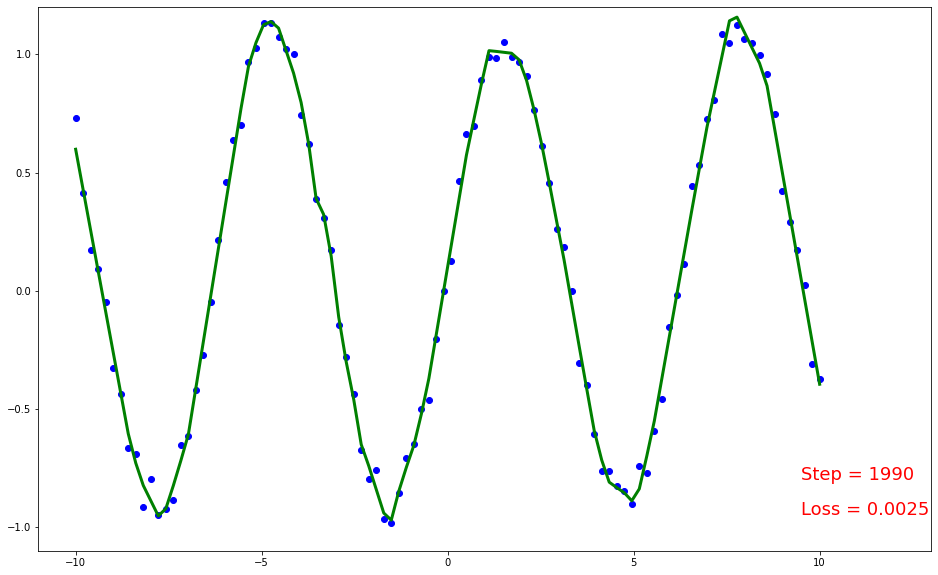

In [11]:
#training
my_images = []
fig, ax = plt.subplots(figsize=(16,10))
#epochs = 2000
# start training
for t in range(2000):
  
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        ax.set_xlim(-11.0, 13.0)
        ax.set_ylim(-1.1, 1.2)
        ax.scatter(x.data.numpy(), y.data.numpy(), color = "blue")
        ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
        ax.text(9.50, -0.8, 'Step = %d' % t, fontdict={'size': 18, 'color':  'red'})
        ax.text(9.50, -0.95, 'Loss = %.4f' % loss.data.numpy(),
                fontdict={'size': 18, 'color':  'red'})

        # Used to return the plot as an image array 
        # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        my_images.append(image)
    
    


# save images as a gif    
imageio.mimsave('./curve_2_bignet.gif', my_images, fps=10)

In [12]:
#we want to store the model that we train!
torch.save(net.state_dict(),"net_sinx.pth")
print("model trained and stored at net_six.pth")

model trained and stored at net_six.pth


even better!

### Make predictions

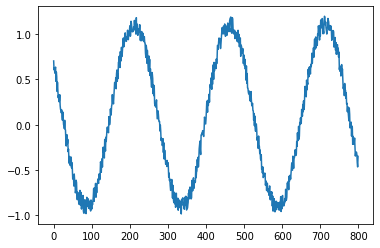

In [13]:
x = torch.unsqueeze(torch.linspace(-10, 10, 800), dim=1) 

y = torch.sin(x) + 0.2*torch.rand(x.size())  
x, y = Variable(x), Variable(y)
plt.plot(y)

In [14]:
state_dict = torch.load("net_sinx.pth")
net.load_state_dict(state_dict)
pred = net(x)

In [15]:
loss = loss_func(pred, y)
loss

tensor(0.0049, grad_fn=<MseLossBackward>)

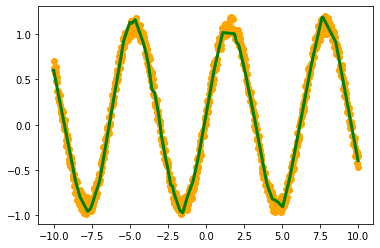

In [16]:
fig, ax = plt.subplots()
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), pred.data.numpy(), 'g-', lw=3)

We can see that we trained the model in 100 points with t in T=(-10,10) and it works very good also for 400 points in T. We have now an approximator of time series P(t). Although, if we try the model out of T, we see that it works good for data in T, but it's very bad for data out of T! So, it is not reliable for future predictions of time t:

tensor(0.0202, grad_fn=<MseLossBackward>)


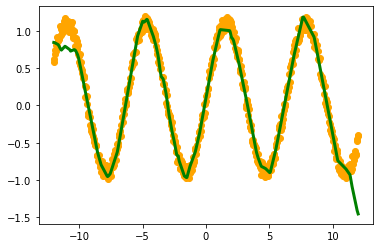

In [19]:
x = torch.unsqueeze(torch.linspace(-12, 12, 600), dim=1) #OUT OF T, FOR EXAMPLE (-12,12)
y = torch.sin(x) + 0.2*torch.rand(x.size())  
pred = net(x)
loss = loss_func(pred, y)
print(loss)
fig, ax = plt.subplots()
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), pred.data.numpy(), 'g-', lw=3)

# Second approach:
One second approach is to use the approximation of P(t) that we found(i.e the avove Neural Network), so P(t) = N(t). Also,
1. As we said, Neural Network is a continues approximator, so we can have the derivative $\frac{dN}{dt}$
2. P(t) = N(t) is the solution of a diff. eq. $$\frac{dP}{dt} = f(t,P(t))$$ which we don't know.
3. suppose $$\frac{dP}{dt} = N1(t) * N(t)$$ where N1(t) is an other Neural Network that we have to train.
4. We want to minimize the loss function $$ E= \frac{1}{2}[\frac{dN}{dt} - N1(t)N(t)]^{2} $$ 


In [20]:
#build model N1(t)
net1 = torch.nn.Sequential(
        torch.nn.Linear(1, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300, 1),
    )

In [21]:
#loss function
def loss(x):

    x.requires_grad = True
    outputs_N = net(x)
    outputs_N1 = net1(x)
    dN_dx = torch.autograd.grad(outputs_N, x, grad_outputs=torch.ones_like(outputs_N),
                        create_graph=True)[0]

    return  torch.mean( ( dN_dx - outputs_N * outputs_N1 )  ** 2)

In [22]:
#optimizer = torch.optim.LBFGS(N.parameters())
optimizer = torch.optim.Adam(net1.parameters(), lr=0.5)

In [24]:
x = torch.unsqueeze(torch.linspace(-10, 10, 500), dim=1) 
x.shape

torch.Size([500, 1])

In [25]:
def closure():

    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    print(f"loss: {l}")
    return l

for i in range(2000):
    optimizer.step(closure)
    print(f"epoch: {i+1}")

loss: 0.7913734316825867
epoch: 1
loss: 23176.015625
epoch: 2
loss: 3014.31982421875
epoch: 3
loss: 5316.91357421875
epoch: 4
loss: 196.44003295898438
epoch: 5
loss: 5206.18798828125
epoch: 6
loss: 4217.58203125
epoch: 7
loss: 199.2014617919922
epoch: 8
loss: 2100.540771484375
epoch: 9
loss: 2290.5791015625
epoch: 10
loss: 359.7824401855469
epoch: 11
loss: 444.54522705078125
epoch: 12
loss: 1535.5382080078125
epoch: 13
loss: 1185.652099609375
epoch: 14
loss: 329.3400573730469
epoch: 15
loss: 346.5857849121094
epoch: 16
loss: 573.312255859375
epoch: 17
loss: 427.2647705078125
epoch: 18
loss: 265.89263916015625
epoch: 19
loss: 336.4312438964844
epoch: 20
loss: 361.1326599121094
epoch: 21
loss: 187.0052490234375
epoch: 22
loss: 63.670677185058594
epoch: 23
loss: 156.9868621826172
epoch: 24
loss: 281.45654296875
epoch: 25
loss: 222.2528076171875
epoch: 26
loss: 63.554203033447266
epoch: 27
loss: 5.467010021209717
epoch: 28
loss: 66.77052307128906
epoch: 29
loss: 126.43754577636719
epoch: 3

In [26]:
loss(x) #so we have N1=net1 with this error and also we trained N=net which is approximation of P(t) with error 0.0038

tensor(0.2652, grad_fn=<MeanBackward0>)

### Step 2: solution
We have $$\frac{dP}{dt}= N1(t)*N(t) = f(t, P(t))$$ , we can solve this diff. eq with a Neural Network(numericaly) or with any other numerical way.

In [27]:
NN = nn.Sequential(nn.Linear(1, 200), nn.Sigmoid(), nn.Linear(200,1, bias=False))
Psi_t = lambda x: x * NN(x)
f = lambda x: net1(x)*net(x)

In [28]:
def loss_fun(x):

    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                        create_graph=True)[0]

    return  torch.mean( ( Psi_t_x - f(x) )  ** 2)

In [29]:
optimizer = torch.optim.Adam(NN.parameters(), lr=0.5)

In [30]:
def closure():

    optimizer.zero_grad()
    l = loss_fun(x)
    l.backward()
    print(f"loss: {l}")
    return l

for i in range(500):
    optimizer.step(closure)
    print(f"itter: {i}")

loss: 0.5129728317260742
itter: 0
loss: 2370.63671875
itter: 1
loss: 135.06394958496094
itter: 2
loss: 440.95172119140625
itter: 3
loss: 1161.70458984375
itter: 4
loss: 815.3316040039062
itter: 5
loss: 282.01300048828125
itter: 6
loss: 7.174444675445557
itter: 7
loss: 134.01292419433594
itter: 8
loss: 380.73785400390625
itter: 9
loss: 418.8616027832031
itter: 10
loss: 231.4696044921875
itter: 11
loss: 48.475738525390625
itter: 12
loss: 34.85276794433594
itter: 13
loss: 120.94314575195312
itter: 14
loss: 162.5243682861328
itter: 15
loss: 119.35774230957031
itter: 16
loss: 40.35606002807617
itter: 17
loss: 5.664242267608643
itter: 18
loss: 36.133689880371094
itter: 19
loss: 78.7657470703125
itter: 20
loss: 77.3945541381836
itter: 21
loss: 37.925601959228516
itter: 22
loss: 7.7187018394470215
itter: 23
loss: 14.233854293823242
itter: 24
loss: 39.483463287353516
itter: 25
loss: 46.56145477294922
itter: 26
loss: 28.143617630004883
itter: 27
loss: 8.055685043334961
itter: 28
loss: 7.21934032

tensor(0.0418, grad_fn=<MeanBackward0>)


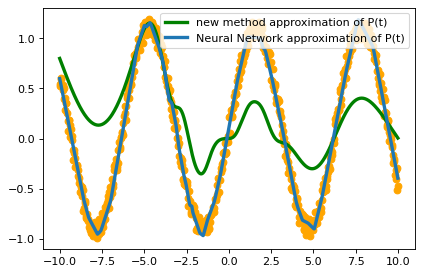

In [31]:
x = torch.unsqueeze(torch.linspace(-10, 10, 600), dim=1) 
y = torch.sin(x) + 0.2*torch.rand(x.size())  
p_t = Psi_t(x)
p_t_N = net(x)
loss = loss_fun(x)
print(loss)
fig, ax = plt.subplots(dpi=80)
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), p_t.data.numpy(), 'g-', lw=3, label ='new method approximation of P(t)')
ax.plot(x.data.numpy(), p_t_N.data.numpy(), lw=3, label ='Neural Network approximation of P(t)')
plt.legend(loc='best');

In [37]:
#Neurodiffeq
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition

## Second Order DE

Suppose $$ \frac{d^{2}P}{dt^{2}} = N1(t)*N(t) = f(t, P(t))$$

In [32]:
NN = nn.Sequential(nn.Linear(1, 200), nn.Sigmoid(), nn.Linear(200,1, bias=False))
Psi_t = lambda x: (1-x)* x * NN(x)

In [33]:
def loss_second_de(x):

    x.requires_grad = True
    outputs = Psi_t(x)

    #we need Psi_x_x 
    #calculating gradient twice 

    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                            create_graph=True)[0]
    Psi_t_x_x = torch.autograd.grad(Psi_t_x, x, grad_outputs=torch.ones_like(Psi_t_x),
                                            create_graph=True )[0]

    return torch.mean((Psi_t_x_x - f(x)) ** 2)

In [34]:
optimizer = torch.optim.Adam(NN.parameters(), lr=0.1)

In [35]:
def closure():
    optimizer.zero_grad()
    l = loss_second_de(x)
    l.backward()
    print(f"loss: {l}")
    return l
    

for i in range(500):
    print(f"itter: {i+1}")
    optimizer.step(closure)

itter: 1
loss: 0.8957660794258118
itter: 2
loss: 372.9120178222656
itter: 3
loss: 24.090526580810547
itter: 4
loss: 71.76338958740234
itter: 5
loss: 197.70932006835938
itter: 6
loss: 157.66595458984375
itter: 7
loss: 52.78250503540039
itter: 8
loss: 1.6273690462112427
itter: 9
loss: 31.537874221801758
itter: 10
loss: 81.92888641357422
itter: 11
loss: 88.92371368408203
itter: 12
loss: 52.783363342285156
itter: 13
loss: 14.315252304077148
itter: 14
loss: 5.33280086517334
itter: 15
loss: 22.691692352294922
itter: 16
loss: 39.37128829956055
itter: 17
loss: 37.504127502441406
itter: 18
loss: 22.030975341796875
itter: 19
loss: 8.105863571166992
itter: 20
loss: 5.100322246551514
itter: 21
loss: 10.39511489868164
itter: 22
loss: 15.684249877929688
itter: 23
loss: 15.289244651794434
itter: 24
loss: 10.07679271697998
itter: 25
loss: 4.801519870758057
itter: 26
loss: 2.897653102874756
itter: 27
loss: 4.268009662628174
itter: 28
loss: 6.536755561828613
itter: 29
loss: 7.260675430297852
itter: 30
l

tensor(0.0248, grad_fn=<MeanBackward0>)


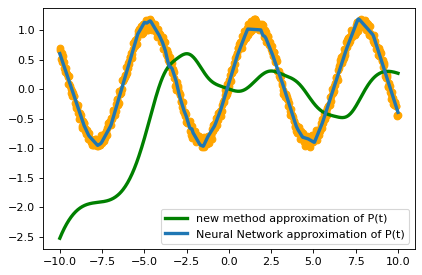

In [36]:
x = torch.unsqueeze(torch.linspace(-10, 10, 600), dim=1) 
y = torch.sin(x) + 0.2*torch.rand(x.size())  
p_t = Psi_t(x)
p_t_N = net(x)
loss = loss_second_de(x)
print(loss)
fig, ax = plt.subplots(dpi=80)
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), p_t.data.numpy(), 'g-', lw=3, label ='new method approximation of P(t)')
ax.plot(x.data.numpy(), p_t_N.data.numpy(), lw=3, label ='Neural Network approximation of P(t)')
plt.legend(loc='best');